In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from astroquery.mast import Observations
from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch

In [2]:
df = pd.read_csv(r'C:\Users\oryan\Documents\zoobot_new\manifests\gz-mergers-coords-all-62.csv',index_col=0)

In [160]:
row = df.iloc[0]
prim_ra = row.Prim_RA
prim_dec = row.Prim_DEC
zooniverse_id = row.Names.strip()

In [161]:
sec_ra = row.Sec_RA
sec_dec = row.Sec_DEC

In [162]:
prim_coord = SkyCoord(ra = prim_ra * u.deg, dec = prim_dec * u.deg, frame='icrs')
sec_coord = SkyCoord(ra = sec_ra * u.deg, dec = sec_dec * u.deg, frame = 'icrs')

In [163]:
pa = prim_coord.position_angle(sec_coord)
sep = prim_coord.separation(sec_coord)
coord = prim_coord.directional_offset_by(pa,sep/2)

In [164]:
obs_table = Observations.query_criteria(
    coordinates = coord,
    radius = 20 * u.arcsec,
    dataproduct_type='image',
    obs_collection = 'HLA',
    calib_level = 3,
    type='S',
    filters = ['F814W', 'F606W', 'F435W', 'g', 'r', 'i']
)

In [165]:
len(obs_table)

10

In [166]:
parent_obs = pd.DataFrame(obs_table.to_pandas().obsid.value_counts()).reset_index().rename(columns={'index':'parent_obsid'}).drop(columns='obsid')

In [167]:
cutoff = np.max(obs_table['t_obs_release']) - 500

In [168]:
wanted_obs = Table.from_pandas(obs_table.to_pandas().sort_values('t_obs_release',ascending=False).query('t_obs_release > @cutoff'))

In [169]:
data_products = Observations.get_product_list(wanted_obs)

In [170]:
download_products = Table.from_pandas(
    data_products
    .to_pandas()
    .query('dataproduct_type == "image"')
    .query('obs_collection == "HLA"')
    .query('type == "C"')
    .query('calib_level == 3')
    .query('productType == "SCIENCE"')
    .merge(parent_obs,on='parent_obsid',how='right')
    .dropna(0,thresh=5)
)

In [171]:
download_products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str5,str29,str29,str1,str79,str7,str28,str3,bytes1,str3,bytes1,str5,str38,object,str8,str6,float64
26066072,HLA,image,hst_mos_0030267_acs_wfc_f435w,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_mos_0030267_acs_wfc_f435w_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,10592,hst_mos_0030267_acs_wfc_f435w_drz.fits,612158400,26066072,PUBLIC,3.0
26066073,HLA,image,hst_mos_0030267_acs_wfc_f814w,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_mos_0030267_acs_wfc_f814w_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,10592,hst_mos_0030267_acs_wfc_f814w_drz.fits,612152640,26066073,PUBLIC,3.0
25708450,HLA,image,hst_10592_49_acs_wfc_f814w,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_10592_49_acs_wfc_f814w_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,10592,hst_10592_49_acs_wfc_f814w_drz.fits,527673600,25708450,PUBLIC,3.0
25708449,HLA,image,hst_10592_49_acs_wfc_f435w,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_10592_49_acs_wfc_f435w_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,10592,hst_10592_49_acs_wfc_f435w_drz.fits,527679360,25708449,PUBLIC,3.0


In [172]:
if os.path.exists(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/'):
    pass
else:
    os.mkdir(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/')

In [173]:
manifest = Observations.download_products(download_products,download_dir = f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}')

INFO: Found cached file C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/Arp240/mastDownload\HLA\hst_mos_0030267_acs_wfc_f435w\hst_mos_0030267_acs_wfc_f435w_drz.fits with expected size 612158400. [astroquery.query]
INFO: Found cached file C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/Arp240/mastDownload\HLA\hst_mos_0030267_acs_wfc_f814w\hst_mos_0030267_acs_wfc_f814w_drz.fits with expected size 612152640. [astroquery.query]
INFO: Found cached file C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/Arp240/mastDownload\HLA\hst_10592_49_acs_wfc_f814w\hst_10592_49_acs_wfc_f814w_drz.fits with expected size 527673600. [astroquery.query]
INFO: Found cached file C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/Arp240/mastDownload\HLA\hst_10592_49_acs_wfc_f435w\hst_10592_49_acs_wfc_f435w_drz.fits with expected size 527679360. [astroquery.query]


In [174]:
files = [manifest['Local Path'][1]]

In [175]:
files

['C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/Arp240/mastDownload\\HLA\\hst_mos_0030267_acs_wfc_f814w\\hst_mos_0030267_acs_wfc_f814w_drz.fits']

In [176]:
if len(files) > 1.5:
    hdus = [fits.open(file)[1] for file in files]
    wcs_out, shape_out = find_optimal_celestial_wcs(hdus)
    data,footprint = reproject_and_coadd(hdus, output_projection = wcs_out, shape_out = shape_out, reproject_function = reproject_interp)
else:
    file = files[0]
    headers = fits.open(file)[1].header
    data = fits.open(file)[1].data
    wcs_out = wcs.WCS(headers)

In [177]:
prim_pix = np.asarray(prim_coord.to_pixel(wcs_out))
sec_pix = sec_coord.to_pixel(wcs_out)

In [178]:
prim_pix[0] - sec_pix[0]

1788.5590271743972

In [180]:
round((prim_pix[0] - sec_pix[0]) + 800,-2)

2600.0

In [148]:
cutout_size = (prim_pix[1] - sec_pix[1])

In [138]:
cutout = Cutout2D(data,coord,(2000,2000),wcs=wcs_out,mode='strict')

In [139]:
wcs_out

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 144.4302164802816  2.763645677407052  
CRPIX : 2577.0  2701.5  
CD1_1 CD1_2  : -1.1005555796954e-05  0.0  
CD2_1 CD2_2  : 0.0  1.10055557969543e-05  
NAXIS : 5154  5403

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


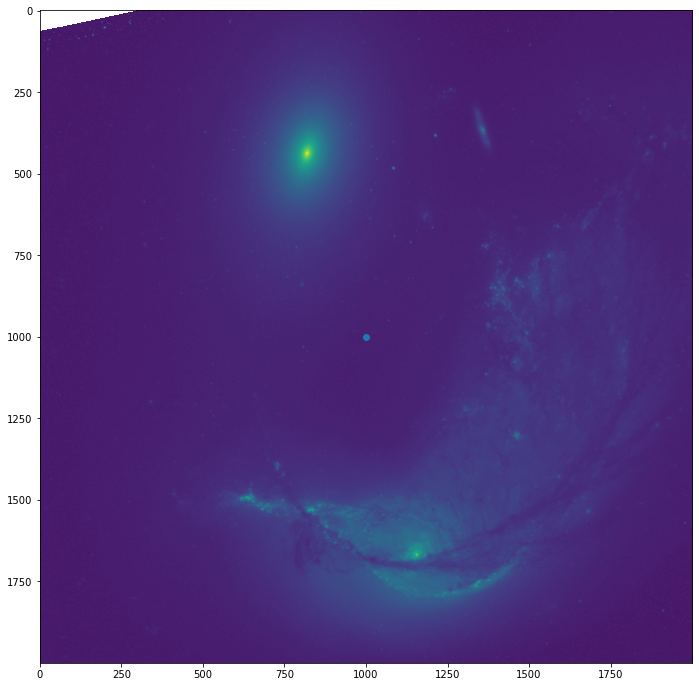

In [140]:
plt.figure(figsize=(12,12))
plt.imshow(np.log10(cutout.data))
plt.scatter(cutout.data.shape[0]/2,cutout.data.shape[1]/2)

In [141]:
cutout.data[cutout.data == 0] = np.nanmin(cutout.data[cutout.data != 0.0])

In [142]:
norm = ImageNormalize(cutout.data,interval=ZScaleInterval(nsamples=7500,contrast=0.05),stretch=LinearStretch(),clip=False)

In [143]:
len(cutout.data[cutout.data == 0])

0

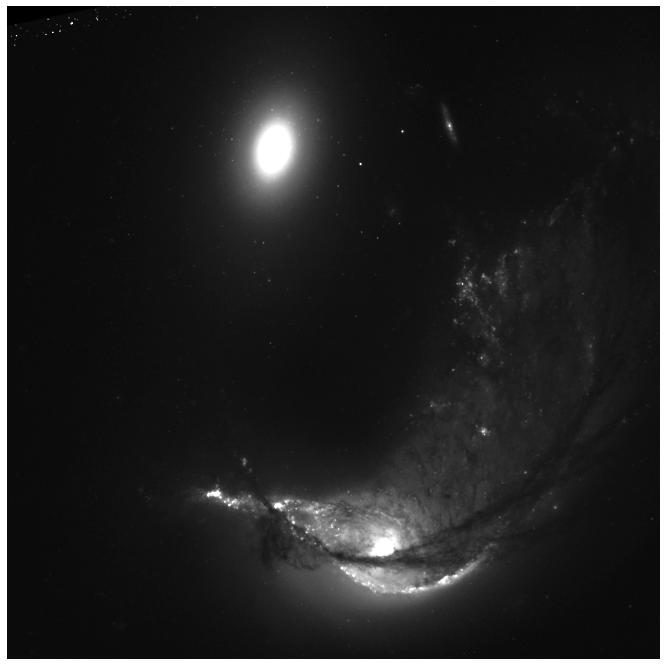

In [144]:
plt.figure(figsize=(12,12))
plt.imshow(cutout.data,cmap='Greys_r',norm=norm)
plt.axis('off')
plt.savefig(f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{zooniverse_id}/{zooniverse_id}.png',dpi=300,bbox_inches='tight',pad_inches=0)